# データマイニング

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error


import warnings
warnings.simplefilter('ignore')

In [2]:
#データのダウンロード
train=pd.read_csv("c:/probspace/train_data.csv")
test=pd.read_csv("c:/probspace/test_data.csv")
sub=pd.read_csv("c:/probspace/submission.csv")

In [3]:
#データの大きさを見る
print(train.shape)
print("----------------")
print(test.shape)

(21000, 13)
----------------
(9000, 12)


In [4]:
train.head()

,id,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,salary
0,0,1,44,愛知県,2,1,2,1,24,2.0,1.6,9.2,428.074887
1,1,2,31,奈良県,1,0,0,0,13,9.0,0.7,12.4,317.930517
2,2,2,36,山口県,1,0,0,2,14,4.0,0.4,16.9,357.350316
3,3,0,22,東京都,2,0,0,0,4,3.0,0.4,6.1,201.310911
4,4,0,25,鹿児島県,2,0,0,1,5,3.0,0.2,4.9,178.067475


In [5]:
test.head()

,id,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime
0,0,3,39,鹿児島県,2,1,5,1,19,1.0,1.8,14.2
1,1,1,31,宮城県,1,0,0,4,0,0.0,0.5,18.6
2,2,0,20,愛知県,2,1,2,0,2,2.0,1.2,2.3
3,3,0,28,三重県,2,0,0,0,10,3.0,0.3,0.0
4,4,1,41,愛媛県,2,0,0,0,23,3.0,0.5,10.1


In [6]:
#データの欠損値の確認
print(train.isnull().sum())
print("-----------------------")
print(test.isnull().sum())

id                0
position          0
age               0
area              0
sex               0
partner           0
num_child         0
education         0
service_length    0
study_time        0
commute           0
overtime          0
salary            0
dtype: int64
-----------------------
id                0
position          0
age               0
area              0
sex               0
partner           0
num_child         0
education         0
service_length    0
study_time        0
commute           0
overtime          0
dtype: int64


# 特徴量生成

* 残業時間0にラベル付け

In [7]:
def zero_over(df):
    df['zero_over']=0
    df.loc[df['overtime']==0,'zero_over']=1
    df.loc[df['overtime']>0,'zero_over']=0
    return df

In [8]:
train=zero_over(train)
test=zero_over(test)

* 大都市にラベル付け

In [9]:
def urban(df):
    df['urban']=0
    df.loc[(df['area']=='東京都')|(df['area']=='神奈川')|(df['area']=='大阪府'),'urban']=1
    return df

In [10]:
train=urban(train)
test=urban(test)

In [11]:
train.head()

,id,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,salary,zero_over,urban
0,0,1,44,愛知県,2,1,2,1,24,2.0,1.6,9.2,428.074887,0,0
1,1,2,31,奈良県,1,0,0,0,13,9.0,0.7,12.4,317.930517,0,0
2,2,2,36,山口県,1,0,0,2,14,4.0,0.4,16.9,357.350316,0,0
3,3,0,22,東京都,2,0,0,0,4,3.0,0.4,6.1,201.310911,0,1
4,4,0,25,鹿児島県,2,0,0,1,5,3.0,0.2,4.9,178.067475,0,0


In [12]:
test.head()

,id,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,zero_over,urban
0,0,3,39,鹿児島県,2,1,5,1,19,1.0,1.8,14.2,0,0
1,1,1,31,宮城県,1,0,0,4,0,0.0,0.5,18.6,0,0
2,2,0,20,愛知県,2,1,2,0,2,2.0,1.2,2.3,0,0
3,3,0,28,三重県,2,0,0,0,10,3.0,0.3,0.0,1,0
4,4,1,41,愛媛県,2,0,0,0,23,3.0,0.5,10.1,0,0


# 前処理

In [13]:
#id列の除去
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

In [14]:
cat_features=["position","area", "sex", "partner", "education","urban","zero_over"]
num_features=["age", "num_child", "service_length", "study_time", "commute", "overtime"]

In [15]:
#trainデータを説明変数と被説明変数に分ける
X_train=train.drop(['salary'],axis=1)
y_train=train['salary']

#残業時間の分布を確認
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(X_train['overtime'],ax=axis1)
sns.distplot(test['overtime'],ax=axis2)

#残業時間0を平均で埋め合わせる
X_train['overtime'].replace(0,X_train['overtime'].mean(),inplace=True)
test['overtime'].replace(0,test['overtime'].mean(),inplace=True)

#変化後の確認
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(X_train['overtime'],ax=axis1)
sns.distplot(test['overtime'],ax=axis2)

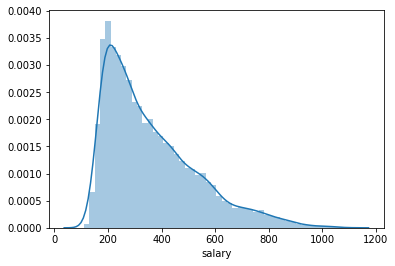

In [16]:
#給料の分布を見る
sns.distplot(y_train)

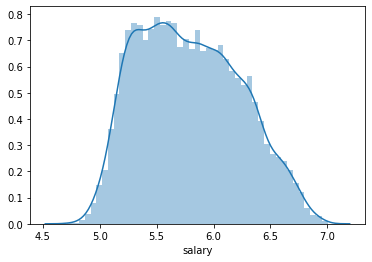

In [17]:
#給料を対数化し、分布をみる
sns.distplot(y_train.map(np.log1p))

In [18]:
#給料を対数化
y_train=y_train.map(np.log1p)

In [19]:
#スケール変換
sc=StandardScaler()
sc.fit(X_train[num_features])

X_train[num_features]=sc.transform(X_train[num_features])
test[num_features]=sc.transform(test[num_features])

#'area'をLabel Encoding
le=LabelEncoder()
le.fit(X_train['area'])
X_train['area']=le.transform(X_train['area'])
test['area']=le.transform(test['area'])

In [20]:
#cat_featuresをtarget encoding
for c in cat_features:
    # 学習データ全体で、各カテゴリの置けるsalaryの平均を計算
    data_tmp = pd.DataFrame({c: X_train[c], "salary": y_train})
    target_mean = data_tmp.groupby(c)["salary"].mean()
    # テストデータのカテゴリを置換
    test[c] = test[c].map(target_mean).astype(np.float)

    # 学習データの変換後の値を格納する配列を準備
    tmp=np.repeat(np.nan,X_train.shape[0])

    # 学習データを分割
    kf = KFold(n_splits=4, shuffle=True, random_state=0)
    for idx_1, idx_2 in kf.split(X_train):
        target_mean = data_tmp.iloc[idx_1].groupby(c)["salary"].mean()
        tmp[idx_2] = X_train[c].iloc[idx_2].map(target_mean)
    X_train[c] = tmp

In [21]:
X_train.head()

,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,zero_over,urban
0,5.812393,1.014236,5.853981,5.771497,5.881186,0.705740,5.706343,1.093515,-0.551935,0.811811,-0.531241,5.790988,5.783976
1,6.093117,-0.199018,5.785268,5.811797,5.702492,-0.705269,5.668963,0.065148,1.561051,-0.540980,0.049598,5.792680,5.785502
2,6.096153,0.267618,5.767643,5.809330,5.701329,-0.705269,5.866405,0.158636,0.051775,-0.991911,0.866402,5.790988,5.783976
3,5.376703,-1.038963,5.940526,5.771497,5.701329,-0.705269,5.671893,-0.776244,-0.250080,-0.991911,-1.093928,5.790988,5.941288
4,5.378119,-0.758981,5.757765,5.763706,5.694858,-0.705269,5.702804,-0.682756,-0.250080,-1.292531,-1.311742,5.785746,5.779790


In [22]:
test.head()

,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,zero_over,urban
0,6.237654,0.547600,5.757539,5.77037,5.879652,2.822253,5.707234,0.626075,-0.853790,1.112431,0.376319,5.789901,5.783201
1,5.812333,-0.199018,5.790757,5.80868,5.699766,-0.705269,6.467226,-1.150195,-1.155645,-0.841601,1.174972,5.789901,5.783201
2,5.378069,-1.225618,5.853726,5.77037,5.879652,0.705740,5.670317,-0.963219,-0.551935,0.210570,-1.783674,5.789901,5.783201
3,5.378069,-0.479000,5.806195,5.77037,5.699766,-0.705269,5.670317,-0.215316,-0.250080,-1.142221,-2.201151,5.766725,5.783201
4,5.812333,0.734254,5.771446,5.77037,5.699766,-0.705269,5.670317,1.000027,-0.250080,-0.841601,-0.367880,5.789901,5.783201


In [23]:
X_train.head()

,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,zero_over,urban
0,5.812393,1.014236,5.853981,5.771497,5.881186,0.705740,5.706343,1.093515,-0.551935,0.811811,-0.531241,5.790988,5.783976
1,6.093117,-0.199018,5.785268,5.811797,5.702492,-0.705269,5.668963,0.065148,1.561051,-0.540980,0.049598,5.792680,5.785502
2,6.096153,0.267618,5.767643,5.809330,5.701329,-0.705269,5.866405,0.158636,0.051775,-0.991911,0.866402,5.790988,5.783976
3,5.376703,-1.038963,5.940526,5.771497,5.701329,-0.705269,5.671893,-0.776244,-0.250080,-0.991911,-1.093928,5.790988,5.941288
4,5.378119,-0.758981,5.757765,5.763706,5.694858,-0.705269,5.702804,-0.682756,-0.250080,-1.292531,-1.311742,5.785746,5.779790


# パラメータチューニング

In [24]:
train_X,valid_X,train_y,valid_y=train_test_split(X_train,y_train,test_size=0.25,random_state=0)

In [25]:
#適当にパラメータ設定
params={'objective':'fair',
        'metric':'fair',
        'learning_rate':0.01,
        'n_estimators':10000,
        #'num_leaves':160,
        'early_stopping_rounds':200}

lgb_train = lgb.Dataset(train_X, train_y)
lgb_val = lgb.Dataset(valid_X, valid_y,reference=lgb_train)
#学習
model=lgb.train(params,
                lgb_train,
                valid_sets=lgb_val,
                verbose_eval=200)

In [26]:
#交差検証(KFold=5)
models = []
n=5
kf = KFold(n_splits=n, random_state=0)
scores = []

pred_cv = np.zeros(len(test.index))


for i, (tdx, vdx) in enumerate(kf.split(X_train, y_train)):
    print(f'Fold : {i}')
    X_tr, X_va, y_tr, y_va = X_train.iloc[tdx], X_train.iloc[vdx], y_train[tdx], y_train[vdx]
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_va, y_va)
    model=lgb.train(params,
                lgb_train,
                valid_sets=lgb_val,
                #categorical_feature=cat_features,
                verbose_eval=200)
    va_pred=np.expm1(model.predict(X_va))
    kf_score=mean_absolute_error(np.expm1(y_va),va_pred)
    print(kf_score)
    scores.append(kf_score)
    models.append(model)
    
    submission = np.expm1(model.predict(test, num_iteration=model.best_iteration)) 
    pred_cv += submission/n

print("-----------------------")
print('平均スコア',np.mean(scores))

#subの書き換え
sub['y']=pd.DataFrame(pred_cv)
sub.to_csv('submission.csv',index=False)

Fold : 0
Training until validation scores don't improve for 200 rounds
[200]	valid_0's fair: 0.00569014
[400]	valid_0's fair: 0.00394603
[600]	valid_0's fair: 0.00366588
[800]	valid_0's fair: 0.00356943
[1000]	valid_0's fair: 0.00352862
[1200]	valid_0's fair: 0.00350732
[1400]	valid_0's fair: 0.00348867
[1600]	valid_0's fair: 0.00348337
[1800]	valid_0's fair: 0.00347448
[2000]	valid_0's fair: 0.0034653
[2200]	valid_0's fair: 0.0034525
[2400]	valid_0's fair: 0.00344749
[2600]	valid_0's fair: 0.00344228
[2800]	valid_0's fair: 0.00343897
Early stopping, best iteration is:
[2753]	valid_0's fair: 0.00343807
22.913096560826478
Fold : 1
Training until validation scores don't improve for 200 rounds
[200]	valid_0's fair: 0.0058154
[400]	valid_0's fair: 0.00403277
[600]	valid_0's fair: 0.00371044
[800]	valid_0's fair: 0.00361892
[1000]	valid_0's fair: 0.00356768
[1200]	valid_0's fair: 0.00352986
[1400]	valid_0's fair: 0.00350686
[1600]	valid_0's fair: 0.00349432
[1800]	valid_0's fair: 0.00348607

In [27]:
#提出物の確認
sub['y'].head()

0    517.558445
1    267.433314
2    206.678933
3    157.717772
4    294.260572
Name: y, dtype: float64

#num_leaves:64 label   CV:23.308405150398766 LB:23.971
#num_leaves:64 target  CV:22.548894068025497 LB:23.533
#num_leaves:124   CV:22.360627641664355 LB:23.127

#予測
pred=np.expm1(model.predict(test))

#submissionの書き換え
sub['y']=pd.DataFrame(np.expm1(pred_cv))
sub.to_csv('submission.csv',index=False)

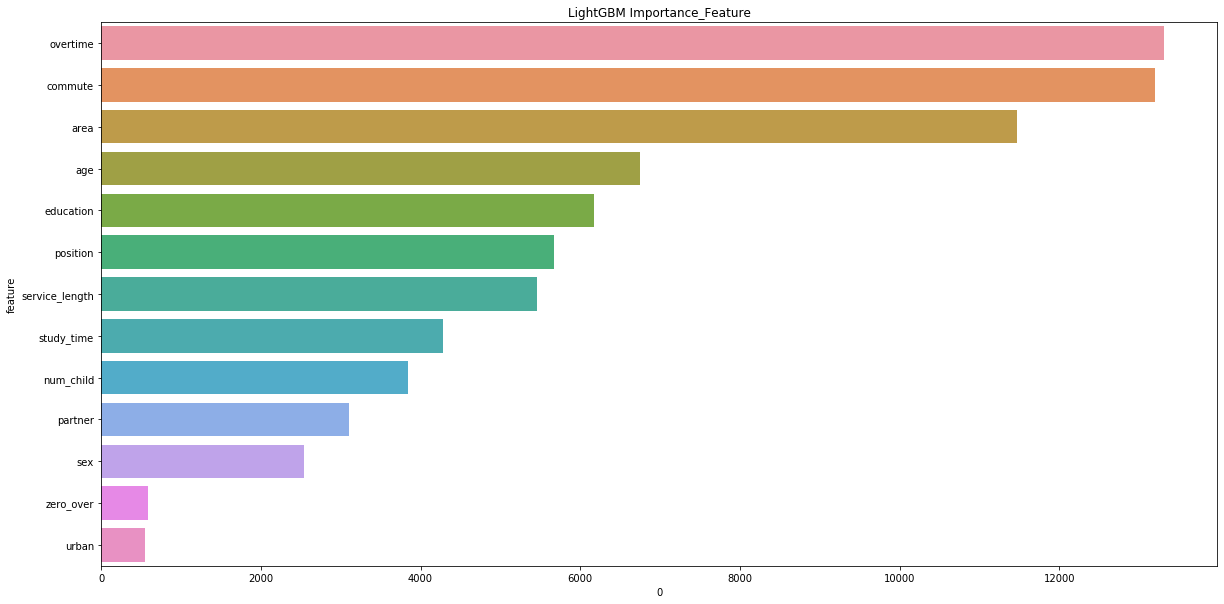

In [28]:
importance = pd.DataFrame(sorted(zip(model.feature_importance(),test.columns),reverse=True),columns={'0','feature'})
plt.figure(figsize=(20, 10))
sns.barplot(x="0", y="feature", data=importance)
plt.title('LightGBM Importance_Feature')
plt.show()